In [1]:
import numpy as np
from dipy.tracking import utils
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import load_tractogram, save_tractogram
from dipy.io.utils import (create_nifti_header, get_reference_info,
                           is_header_compatible)
from dipy.io.image import load_nifti_data, load_nifti, save_nifti
import nibabel as nib
from matplotlib import pyplot as plt
from dipy.align.reslice import reslice
from dipy.align.imaffine import (MutualInformationMetric, AffineRegistration, transform_origins)
from dipy.align.transforms import (TranslationTransform3D, RigidTransform3D, AffineTransform3D)
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric
from dipy.tracking.streamline import deform_streamlines
from dipy.viz import has_fury, window, actor
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_tractogram
from dipy.viz import regtools

In [2]:
def show_template_bundles(bundles, show=True, fname=None):

    scene = window.Scene()
    template_actor = actor.slicer(static)
    scene.add(template_actor)

    lines_actor = actor.streamtube(bundles, window.colors.orange,
                                   linewidth=0.3)
    scene.add(lines_actor)

    if show:
        window.show(scene)
    if fname is not None:
        window.record(scene, n_frames=1, out_path=fname, size=(900, 900))

Load the tractogram with its header

In [3]:
kable = load_tractogram('Track0.trk', 'same')

Print its info

In [4]:
print(kable)

Affine: 
[[-1.000000 -0.000000 -0.000000 64.644043]
 [0.000000 1.000000 -0.000000 -81.753418]
 [-0.000000 0.000000 1.000000 -82.853210]
 [0.000000 0.000000 0.000000 1.000000]]
dimensions: [138 168 152]
voxel_sizes: [1.00 1.00 1.00]
voxel_order: LAS
streamline_count: 334253
point_count: 14954414
data_per_streamline keys: []
data_per_point keys: []


In [5]:
affineT, dimensions, voxel_sizes, voxel_order = get_reference_info(kable)

Load a reference B0 image to register to the atlas space. We'll probably need to reslice it and crop the atlas or sth like that.

In [6]:
B0_im, B0_affine = load_nifti('b0_resampled.nii.gz')
np.unique(B0_im.shape == dimensions)

array([ True])

The shape of our B0 reference image is the same as the tractogram, fortunately.
Now we load the atlas. As it can be seen, the dimension is different from the B0. Multiresolution registration will be performed between these two images. (B0 -> ATLAS)

In [7]:
atlas, atlas_affine = load_nifti('BN_Atlas_246_1mm.nii.gz')
std_im, std_affine, prev_voxel_size = load_nifti('HCP40_MNI_1.25mm.nii.gz', return_voxsize=True)
print(std_im.shape)
print(type(std_im))
print(atlas.shape)
type(atlas)

(145, 173, 145)
<class 'numpy.ndarray'>
(182, 218, 182)


numpy.ndarray

The dimensions of the standard space of the atlas and the atlas itself do not match because the voxel sizes of these volumes are different. We need to reslice the std image (1.25 mm voxel) to the atlas voxel size (1 mm)

ATLAS dimensions = (182, 218, 182)
Resliced standard image dimensions = (181, 216, 181)
There is a little offset in the dimensions. (Why?)


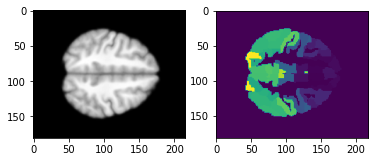

In [8]:
new_voxel_size = (1., 1., 1.)
std_im_rs, std_affine_rs = reslice(std_im, std_affine, prev_voxel_size, new_voxel_size)
print('ATLAS dimensions = ' + str(atlas.shape))
print('Resliced standard image dimensions = ' + str(std_im_rs.shape))
plt.subplot(121)
plt.imshow(std_im_rs[:,:, 120], cmap='gray')
plt.subplot(122)
plt.imshow(atlas[:,:, 120])
std_im = std_im_rs
std_affine = std_affine_rs # Overwrite the resliced volumes.
print('There is a little offset in the dimensions. (Why?)')

Time to register the B0 image to the standard space image. (B0 -> STD)

In [9]:
static = std_im
static_affine = std_affine
moving = B0_im
moving_affine = B0_affine

Estimate affine that maps the origin of the moving image to that of the static image.

In [10]:
affine_map = transform_origins(static, static_affine, moving, moving_affine)
affine_map

array([[  1.        ,   0.        ,   0.        , -25.35595703],
       [  0.        ,   1.        ,   0.        ,  44.24658203],
       [  0.        ,   0.        ,   1.        , -10.85321045],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

Mismatch metric and optimization strategy.

In [11]:
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)
level_iters = [10, 10, 5]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]
affine_reg = AffineRegistration(metric=metric, level_iters=level_iters,
                                sigmas=sigmas, factors=factors)
transform = TranslationTransform3D()

params0 = None
translation = affine_reg.optimize(static, moving, transform, params0,
                                  static_affine, moving_affine)
transformed = translation.transform(moving)
transform = RigidTransform3D()

rigid_map = affine_reg.optimize(static, moving, transform, params0,
                                static_affine, moving_affine,
                                starting_affine=translation.affine)
transformed = rigid_map.transform(moving)
transform = AffineTransform3D()

Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]


In [12]:
affine_reg.level_iters = [20, 20, 5]
highres_map = affine_reg.optimize(static, moving, transform, params0,
                                  static_affine, moving_affine,
                                  starting_affine=rigid_map.affine)
transformed = highres_map.transform(moving)

Optimizing level 2 [max iter: 20]
Optimizing level 1 [max iter: 20]
Optimizing level 0 [max iter: 5]


In [13]:
metric = CCMetric(3)
level_iters = [10, 10, 5]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters)

mapping = sdr.optimize(static, moving, static_affine, moving_affine,
                       highres_map.affine)
warped_moving = mapping.transform(moving)

Visualize the registration. Looks good.

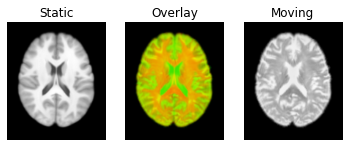

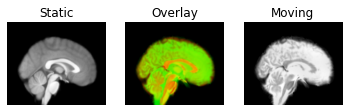

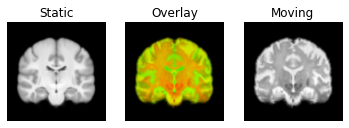

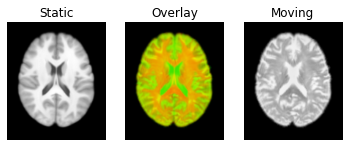

In [14]:
regtools.overlay_slices(static, warped_moving, None, 0, 'Static', 'Moving',
                        'transformed_sagittal.png')
regtools.overlay_slices(static, warped_moving, None, 1, 'Static', 'Moving',
                        'transformed_coronal.png')
regtools.overlay_slices(static, warped_moving, None, 2, 'Static', 'Moving',
                        'transformed_axial.png')

Now we need to apply the INVERSE of the deformation field that was applied in the B0->STD registration to the atlas. This way we deform the atlas to the Track space (which is the same as the B0 space). The previous registration procedure was used just for extracting this deformation field.

In [15]:
vox_size = 1
# Create an isocentered affine
target_isocenter = np.diag(np.array([-vox_size, vox_size, vox_size, 1]))
# Take the off-origin affine capturing the extent contrast between the mean B0 image and the template
origin_affine = affine_map.affine.copy()
origin_affine[0][3] = -origin_affine[0][3]
origin_affine[1][3] = -origin_affine[1][3]

In [16]:
mni_streamlines = deform_streamlines(
    kable.streamlines, deform_field=mapping.get_forward_field(),
    stream_to_current_grid=target_isocenter,
    current_grid_to_world=origin_affine, stream_to_ref_grid=target_isocenter,
    ref_grid_to_world=np.eye(4))

Convert the standard image to Nifti format to store as the streamlines reference

In [17]:
std_Nifti = nib.Nifti1Image(std_im, std_affine)

In [18]:
sft = StatefulTractogram(mni_streamlines, std_Nifti, Space.RASMM)
save_tractogram(sft, 'mni-lr-superiorfrontal.trk', bbox_valid_check=False)

True

In [19]:
tracks_affine, dims, voxel_szs, voxel_ords = get_reference_info(sft)
print(tracks_affine)

[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]


Example for connectivity matrix

In [22]:
M, grouping = utils.connectivity_matrix(sft,tracks_affine, label_volume=atlas.astype(np.uint8), return_mapping=False, mapping_as_streamlines=False)

ValueError: slice step cannot be zero